In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, roc_auc_score,
    RocCurveDisplay, ConfusionMatrixDisplay
)
from sklearn.decomposition import PCA
import numpy as np

# Silence noisy warnings
from sklearn.exceptions import ConvergenceWarning
from cryptography.utils import CryptographyDeprecationWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=CryptographyDeprecationWarning)

In [2]:
# Load dataset
df = pd.read_csv("online_retail.csv", encoding="ISO-8859-1", parse_dates=["InvoiceDate"])

# Basic cleaning
df = df.drop_duplicates()
df = df.dropna(subset=["InvoiceNo", "StockCode", "InvoiceDate", "UnitPrice"])

In [3]:
# Cancellation & line totals
df["IsCancelled"] = df["InvoiceNo"].astype(str).str.startswith("C").astype(int)
df["LineTotal"] = df["Quantity"] * df["UnitPrice"]

# Fill CustomerID with sentinel
df["CustomerID"] = df["CustomerID"].fillna(-1).astype(int).astype(str)

print(df.shape)
print(df.IsCancelled.value_counts(normalize=True))

(536641, 10)
IsCancelled
0    0.982761
1    0.017239
Name: proportion, dtype: float64


<Figure size 640x480 with 0 Axes>

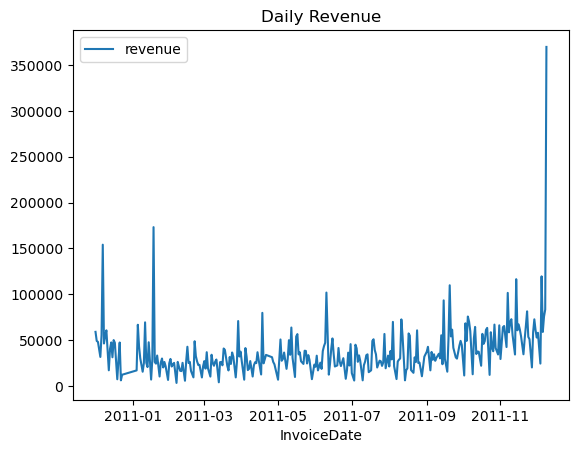

<Figure size 640x480 with 0 Axes>

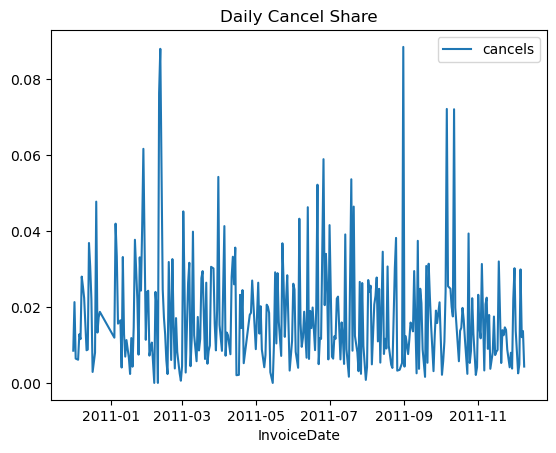

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Daily revenue (abs for clarity), and daily cancellation share
daily = df.assign(AbsLine=np.abs(df["LineTotal"])) \
          .groupby(df["InvoiceDate"].dt.date).agg(
              revenue=("AbsLine","sum"),
              cancels=("IsCancelled","mean"),
          ).reset_index()

plt.figure(); daily.plot(x="InvoiceDate", y="revenue"); plt.title("Daily Revenue"); plt.show()
plt.figure(); daily.plot(x="InvoiceDate", y="cancels"); plt.title("Daily Cancel Share"); plt.show()

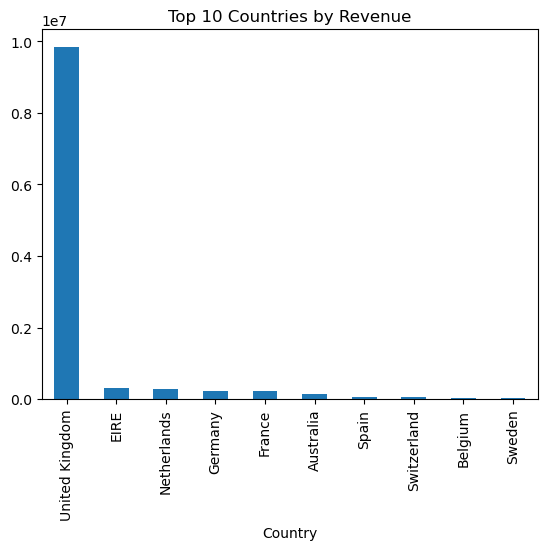

In [5]:
# Top countries by revenue
country_rev = df.assign(AbsLine=np.abs(df["LineTotal"])) \
                .groupby("Country")["AbsLine"].sum().sort_values(ascending=False).head(10)
plt.figure(); country_rev.plot(kind="bar"); plt.title("Top 10 Countries by Revenue"); plt.show()

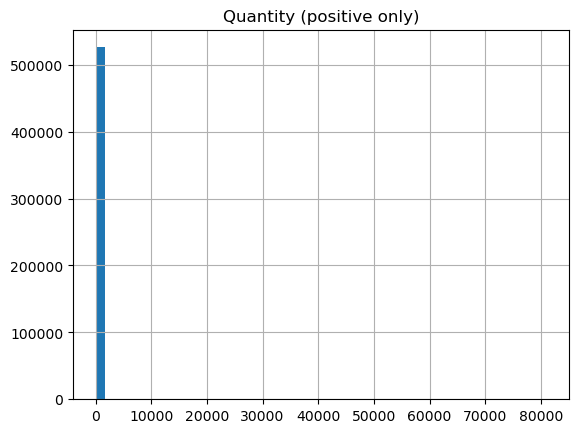

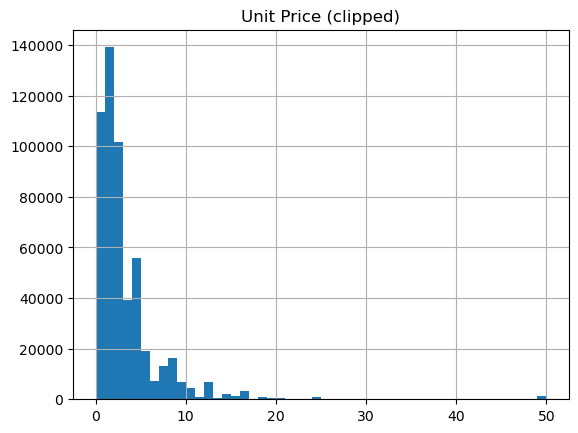

In [6]:
# Quantity/price distributions
plt.figure(); df.loc[df["Quantity"]>0, "Quantity"].hist(bins=50); plt.title("Quantity (positive only)"); plt.show()
plt.figure(); df["UnitPrice"].clip(0, 50).hist(bins=50); plt.title("Unit Price (clipped)"); plt.show()

In [7]:
g = df.groupby("InvoiceNo")

agg = g.agg(
    Country=("Country", lambda s: s.mode().iat[0] if not s.mode().empty else "Unknown"),
    CustomerID=("CustomerID", lambda s: s.mode().iat[0] if not s.mode().empty else "-1"),
    NumLines=("StockCode", "nunique"),
    TotalQty=("Quantity", "sum"),
    NumItems=("Quantity", lambda s: s.abs().sum()),
    NumSKUs=("StockCode", "nunique"),
    InvoiceTotal=("LineTotal", "sum"),
    AvgUnitPrice=("UnitPrice", "mean"),
    FirstTime=("InvoiceDate", "min"),
    LastTime=("InvoiceDate", "max"),
).reset_index()

# Time features
agg["Hour"] = pd.to_datetime(agg["FirstTime"]).dt.hour
agg["DayOfWeek"] = pd.to_datetime(agg["FirstTime"]).dt.dayofweek

# Target
inv_target = g["IsCancelled"].max().reset_index().rename(columns={"IsCancelled":"IsCancelled"})
data = agg.merge(inv_target, on="InvoiceNo", how="left")

# Positive magnitudes
for c in ["InvoiceTotal","TotalQty","NumItems"]:
    data[f"Abs_{c}"] = data[c].abs()

# Feature groups
cat_cols = ["Country", "CustomerID"]
disc_cols = ["NumLines","NumSKUs","Hour","DayOfWeek"]
num_cols = ["Abs_InvoiceTotal","Abs_TotalQty","Abs_NumItems","AvgUnitPrice"]
feature_cols = cat_cols + disc_cols + num_cols

print("Final dataset shape:", data.shape)

Final dataset shape: (25900, 17)


In [8]:
X = data[feature_cols].copy()
y = data["IsCancelled"].astype(int)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
preprocess = ColumnTransformer(
    transformers=[
        ("cat", ohe, cat_cols),
        ("pass_disc", "passthrough", disc_cols),
        ("pass_num",  "passthrough", num_cols),
    ]
)



=== RandomForest (Real Only) ===
              precision    recall  f1-score   support

           0      0.966     0.962     0.964      6619
           1      0.785     0.804     0.794      1151

    accuracy                          0.938      7770
   macro avg      0.875     0.883     0.879      7770
weighted avg      0.939     0.938     0.939      7770

AUC: 0.9669399455454896


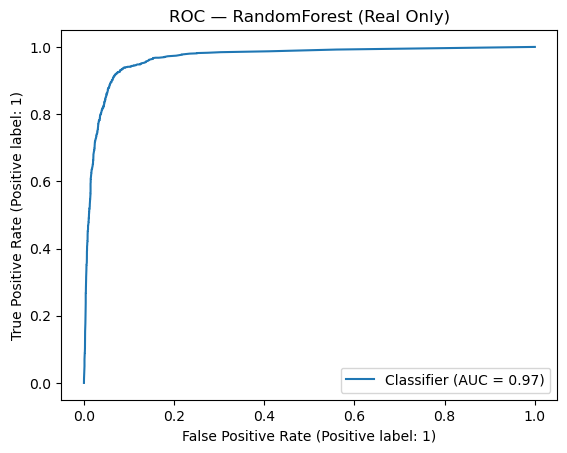

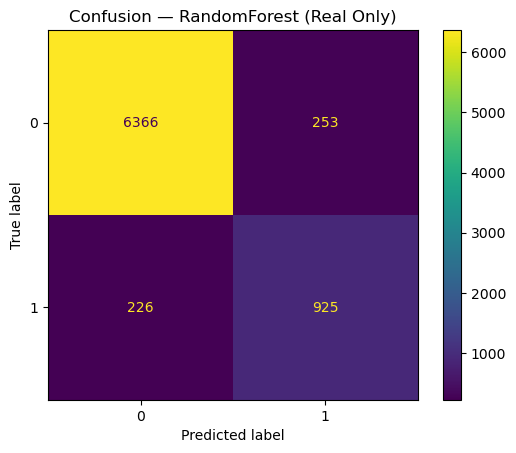


=== LogisticRegression (Real Only) ===
              precision    recall  f1-score   support

           0      0.983     0.860     0.917      6619
           1      0.532     0.917     0.673      1151

    accuracy                          0.868      7770
   macro avg      0.758     0.888     0.795      7770
weighted avg      0.917     0.868     0.881      7770

AUC: 0.9387110454869606


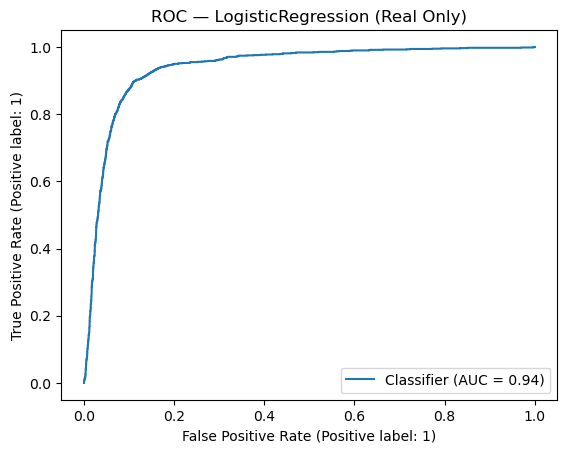

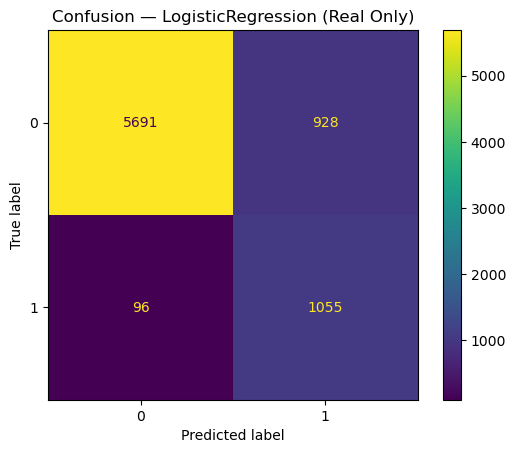

In [9]:
rf_clf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced"))
])
lr_clf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

rf_clf.fit(X_train_raw, y_train)
lr_clf.fit(X_train_raw, y_train)

def eval_model(model, name):
    y_pred = model.predict(X_test_raw)
    y_proba = model.predict_proba(X_test_raw)[:,1]
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=3))
    print("AUC:", roc_auc_score(y_test, y_proba))
    RocCurveDisplay.from_predictions(y_test, y_proba); plt.title(f"ROC — {name}"); plt.show()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred); plt.title(f"Confusion — {name}"); plt.show()

eval_model(rf_clf, "RandomForest (Real Only)")
eval_model(lr_clf, "LogisticRegression (Real Only)")

In [15]:
# Save
metadata.save_to_json("retail_metadata.json")

# Later, reload
from sdv.metadata import Metadata
metadata = Metadata.load_from_json("retail_metadata.json")

In [16]:
from sdv.single_table import GaussianCopulaSynthesizer
gc = GaussianCopulaSynthesizer(metadata)
gc.fit(minority_df)
synthetic_minority = gc.sample(1000)
synthetic_minority["IsCancelled"] = 1

In [17]:
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import Metadata   # new API

minority_df = data.loc[data["IsCancelled"] == 1, feature_cols].copy()
print("Minority samples shape:", minority_df.shape)

metadata = Metadata.detect_from_dataframe(data=minority_df)
ctgan = CTGANSynthesizer(metadata, epochs=80)  # reduce epochs for speed
ctgan.fit(minority_df)

# Balance to ~45%
minority_count = y_train.sum()
majority_count = len(y_train) - minority_count
target_minority = int(0.45 * (majority_count + minority_count))
to_generate = max(0, target_minority - minority_count)

synthetic_minority = pd.DataFrame()
if to_generate > 0:
    synthetic_minority = ctgan.sample(to_generate)
    synthetic_minority["IsCancelled"] = 1

print("Synthetic data shape:", synthetic_minority.shape)

Minority samples shape: (3836, 10)


C:\Users\SMART\.idlerc\New folder\Lib\site-packages\sdv\single_table\base.py:133: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.



PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name   Est # of Columns (CTGAN)
Country                30
CustomerID             1590
NumLines               11
NumSKUs                11
Hour                   11
DayOfWeek              6
Abs_InvoiceTotal       11
Abs_TotalQty           11
Abs_NumItems           11
AvgUnitPrice           11

We recommend preprocessing discrete columns that can have many values, using 'update_transformers'. Or you may drop columns that are not necessary to model. (Exit this script using ctrl-C)
Synthetic data shape: (5473, 11)


In [11]:
train_real = X_train_raw.copy()
train_real["IsCancelled"] = y_train.values

aug_train = pd.concat([train_real, synthetic_minority], ignore_index=True)
X_train_aug = aug_train[feature_cols]
y_train_aug = aug_train["IsCancelled"].astype(int)


=== RandomForest + CTGAN ===
              precision    recall  f1-score   support

           0      0.972     0.954     0.963      6619
           1      0.761     0.839     0.798      1151

    accuracy                          0.937      7770
   macro avg      0.866     0.897     0.881      7770
weighted avg      0.940     0.937     0.938      7770

AUC: 0.9668791721801322


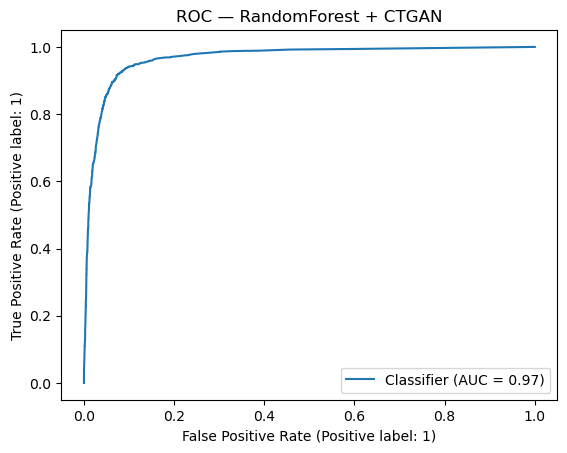

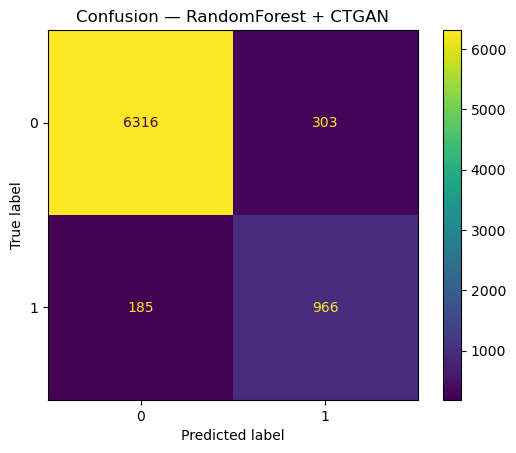


=== LogisticRegression + CTGAN ===
              precision    recall  f1-score   support

           0      0.976     0.925     0.950      6619
           1      0.667     0.870     0.755      1151

    accuracy                          0.916      7770
   macro avg      0.822     0.897     0.852      7770
weighted avg      0.930     0.916     0.921      7770

AUC: 0.944909009933623


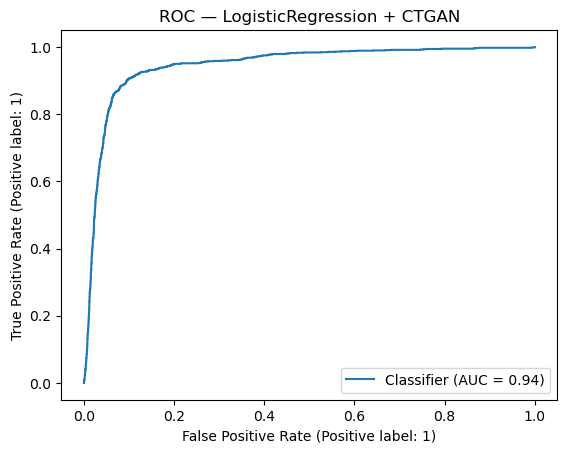

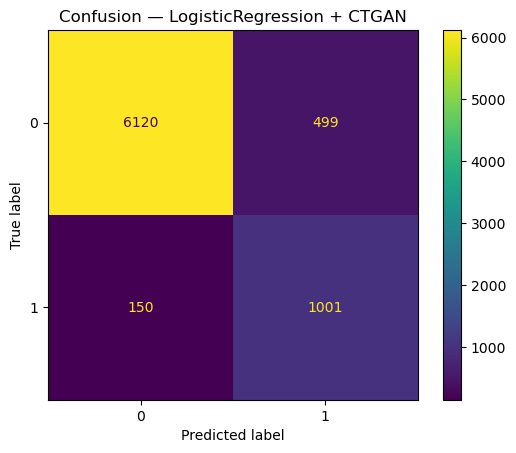

In [12]:
rf_aug = Pipeline(steps=[("prep", preprocess),
                        ("clf", RandomForestClassifier(n_estimators=300, random_state=42))])
lr_aug = Pipeline(steps=[("prep", preprocess),
                        ("clf", LogisticRegression(max_iter=2000))])

rf_aug.fit(X_train_aug, y_train_aug)
lr_aug.fit(X_train_aug, y_train_aug)

eval_model(rf_aug, "RandomForest + CTGAN")
eval_model(lr_aug, "LogisticRegression + CTGAN")


=== RandomForest + CTGAN (Tuned) ===
              precision    recall  f1-score   support

           0      0.972     0.936     0.953      6619
           1      0.695     0.843     0.762      1151

    accuracy                          0.922      7770
   macro avg      0.833     0.889     0.858      7770
weighted avg      0.931     0.922     0.925      7770

AUC: 0.9573798226389055


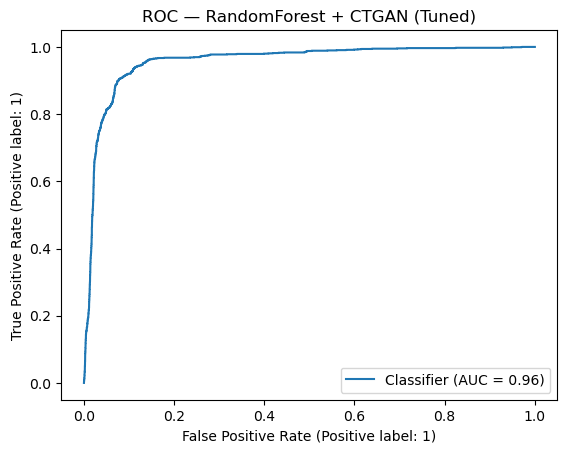

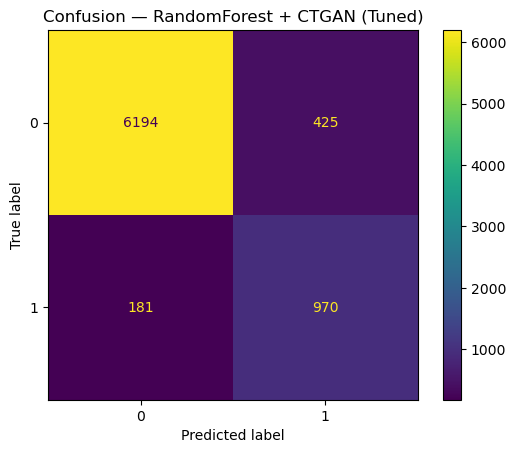

In [13]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {"clf__n_estimators":[200,300,500],
              "clf__max_depth":[None,10,20,30],
              "clf__min_samples_split":[2,5,10]}
search = RandomizedSearchCV(
    rf_aug, param_dist, n_iter=10, scoring="f1", cv=3, random_state=42, n_jobs=-1
)
search.fit(X_train_aug, y_train_aug)
best_model = search.best_estimator_
eval_model(best_model, "RandomForest + CTGAN (Tuned)")

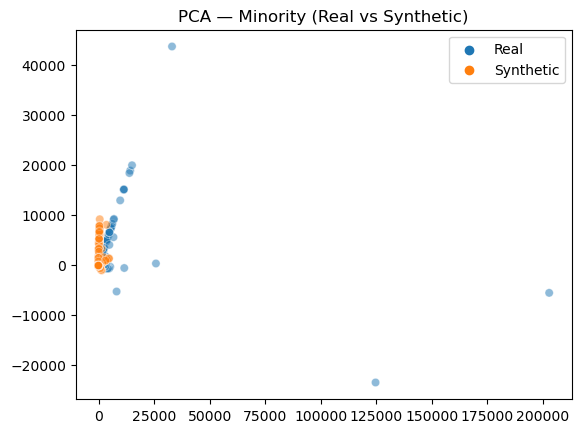

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Use the same preprocessor to get numeric arrays
X_minority_real = preprocess.fit_transform(minority_df)
X_minority_synth = preprocess.transform(synthetic_minority[feature_cols]) if len(synthetic_minority)>0 else None

# PCA (fast, deterministic)
import numpy as np
labels = []
stack = []

stack.append(X_minority_real); labels += ["Real"] * X_minority_real.shape[0]
if X_minority_synth is not None:
    stack.append(X_minority_synth); labels += ["Synthetic"] * X_minority_synth.shape[0]

X_stack = np.vstack(stack)
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X_stack)

plt.figure()
sns.scatterplot(x=Z[:,0], y=Z[:,1], hue=labels, alpha=0.5)
plt.title("PCA — Minority (Real vs Synthetic)")
plt.show()